In [1]:
import numpy as np
import librosa
import os
import pyedflib
import json
import sklearn
import matplotlib.pyplot as plt
import mne
from sklearn.utils import shuffle
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn import neighbors
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, classification_report
from braindecode.augmentation import FTSurrogate
from braindecode.augmentation import SmoothTimeMask
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from scipy.signal import butter, lfilter
from EEGModels import EEGNet

In [2]:
aug_num = 1
time = 6#sec, must be > 1 sec
sampling_period = 125

In [4]:
val_data = np.zeros((1,8,sampling_period*time))
test_data = np.zeros((1,8,sampling_period*time))
val_marks = []
test_marks = []

dir_str = os.path.dirname(os.path.abspath("__file__"))+("\data")
data_dir = Path(dir_str)
print(data_dir)

for file in data_dir.iterdir():
    if file.suffix == ".edf":
        #exclude spoiled files
        if "spoiled" in file.__str__():
            continue

        #exclude noisy files
        #if "noisy" in file.__str__():
        #    continue
        
        loaded_data = mne.io.read_raw_edf(file.__str__())
        loaded_data.load_data()
        
        events = mne.events_from_annotations(loaded_data)
        arr_events = events[0]
        dict = events[1]
        event_names = []
        print(dict)

C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_preprocessing\data
Extracting EDF parameters from C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_preprocessing\data\eeg-02-05-24_12-56.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 608249  =      0.000 ...  4865.992 secs...
Used Annotations descriptions: ['end task', 'right answer', 'start task', 'wrong answer']
{'end task': 1, 'right answer': 2, 'start task': 3, 'wrong answer': 4}
Extracting EDF parameters from C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_preprocessing\data\eeg-02-05-24_13-17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 154999  =      0.000 ...  1239.992 secs...
Used Annotations descriptions: ['end task', 'fake wrong answer', 'right answer', 'start task', 'wrong answer']
{'end task': 1, 'fake wrong answer': 2, 'right answer': 3, 'start task': 4, 'wrong answer': 5}
Extracting EDF parameters from C:\User

In [37]:
val_data = np.zeros((1,8,sampling_period*time))
test_data = np.zeros((1,8,sampling_period*time))
val_marks = []
test_marks = []
loaded_data = []
epochs = []

dir_str = os.path.dirname(os.path.abspath("__file__"))+("\data")
data_dir = Path(dir_str)
print(data_dir)

for file in data_dir.iterdir():
    if file.suffix == ".edf":
        #exclude spoiled files
        if "spoiled" in file.__str__():
            continue

        #exclude noisy files
        #if "noisy" in file.__str__():
        #    continue
        
        loaded_data.append(mne.io.read_raw_edf(file.__str__()))
        loaded_data[-1].load_data()
        loaded_data[-1].set_montage('standard_1020')

        #forming event names array
        events, ev_id = mne.events_from_annotations(loaded_data[-1])
        event_names = {}
        if "right answer" in ev_id:
            event_names["right answer"] = ev_id["right answer"]
        if "right_answer" in ev_id:
            event_names["right_answer"] = ev_id["right_answer"]
        if "fake wrong answer" in ev_id:
            event_names["fake wrong answer"] = ev_id["fake wrong answer"]
        if "wrong answer, shown" in ev_id:
            event_names["wrong answer, shown"] = ev_id["wrong answer, shown"]
        if "wrong answer" in ev_id:
            event_names["wrong answer"] = ev_id["wrong answer"]
        if "wrong_answer" in ev_id:
            event_names["wrong_answer"] = ev_id["wrong_answer"]
        print(event_names)
        

        #add filters
        iir_params = {'order':4, 'ftype':"butter"}
        loaded_data[-1].filter(2.,45., method='iir', iir_params=iir_params)
        #loaded_data_arr = np.array(loaded_data.get_data())
        #if loaded_data_arr.shape[1] < (3*sampling_period*time):
        #    continue
        #nyq = 62
        #inter = loaded_data_arr.shape[1]
        #filtered_data = np.zeros((1,inter)) 
        #b, a = butter(N=4, Wn=[2,40], btype='bandpass', fs=sampling_period, output='ba')
        #for i in range(8):
            #print(loaded_data_arr.shape)
            #filt = lfilter(b, a, loaded_data_arr[i].copy())
            #print(filt.shape)
            #filt = filt.reshape(1,filt.shape[0])
            #print(filt.shape)
            #filtered_data = np.concatenate((filtered_data, filt), axis=0)
            #print(filtered_data.shape)
        #filtered_data = filtered_data[1:,:]
        #filter = loaded_data.copy().filter(l_freq=None, h_freq=40., fir_design='firwin', method='iir', iir_params=None)
        #filter = filter.copy().filter(l_freq=2.,h_freq=None, fir_design='firwin', method='iir', iir_params=None)
        #filtered_data = filtered_data.get_data()

        #forming answers event array
        num = 0
        for i in range(events.shape[0]):
            if events[i,2] in event_names:
                if (events[i,0] == events[i+1,0]):
                    break
                num = i
        print(events)
                
        #separate asnwers (125 dots before and 250 dots after = 3 sec)
        marks = []

        tmin = -(time/2-1)
        tmax = time/2+1
        ep = mne.Epochs(
            loaded_data[-1],
            events=events,
            event_id=event_names,
            event_repeated='drop',
            tmin=tmin,
            tmax=tmax,
            baseline=(tmin, tmin),
            picks='data'
        )
        print(ep)
        print(ep.get_data().shape)
        #ans_data = np.zeros((1,8,sampling_period*time))
        for i in range(ep.get_data().shape[0]):
            if arr_events[i,2] in event_names:
                #print(filtered_data.shape)
                #print(arr_events)
                #ans = filtered_data[:,(arr_events[i,0]-sampling_period*(time/2-0.5)):(arr_events[i,0]+sampling_period*(time/2+0.5))]
                #print(ans.shape)
                #ans = ans.reshape(1,ans.shape[0],ans.shape[1])
                #print(ans)
                
                #print(ans.shape)
                #print(ans_data)
                #print(ans_data.shape)
                if(ans.shape[2] < sampling_period*time):
                    continue
                ans_data = np.concatenate((ans_data, ans), axis=0)
                if arr_events[i,2] == event_names[0]:
                    for m in range(aug_num):
                        marks.append(1)
                else:
                    for m in range(aug_num):
                        marks.append(0)
        
        print(ans_data.shape)
        epochs.append(ep)

        ans_data = ans_data[1:,:,:]
        if ("eeg-23-04-24_13-16" in file.__str__()) or ("eeg-23-04-24_13-53" in file.__str__()) or ("eeg-26-05-23_16-58" in file.__str__()) or ("eeg-18-03-24_14-35" in file.__str__()) or ("eeg-16-04-24_11-08" in file.__str__()) or ("eeg-15-03-24_13-26" in file.__str__()) or ("eeg-24-05-23_17-03" in file.__str__()) or ("eeg-09-11-23_14-03" in file.__str__()) or ("eeg-07-11-23_12-48" in file.__str__()) or ("eeg-14-09-23_16-31" in file.__str__()) or ("eeg-14-09-23_17-16" in file.__str__()) or ("eeg-29-09-23_19-37" in file.__str__()):
            val_data = np.concatenate((val_data, ans_data), axis=0)
            val_marks = val_marks + marks
        else:
            test_data = np.concatenate((test_data, ans_data), axis=0)
            test_marks = test_marks + marks
        
val_data = val_data[1:,:,:]
test_data = test_data[1:,:,:]
print(val_data.shape)
print(len(val_marks))
print(test_data.shape)
print(len(test_marks))

C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_preprocessing\data
Extracting EDF parameters from C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_preprocessing\data\eeg-02-05-24_12-56.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 608249  =      0.000 ...  4865.992 secs...
Used Annotations descriptions: ['end task', 'right answer', 'start task', 'wrong answer']
{'right answer': 2, 'wrong answer': 4}
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 45.00 Hz: -6.02, -6.02 dB

[[103525      0      4]
 [105142      0      1]
 [105142      0      3]
 [175357      0      4]
 [176284      0      1]
 [176284      0      3]
 [248866      0      4]
 [249781      0      1]
 [249781      0      3]
 [291505   

NameError: name 'ans_data' is not defined

In [6]:
#marks counter
n=0
for i in test_marks:
    if i == 0:
        n = n + 1
print(n)
print(len(test_marks) - n)

n=0
for i in val_marks:
    if i == 0:
        n = n + 1

print(n)
print(len(val_marks) - n)
print(len(val_marks) + len(test_marks))

248
357
49
21
675


In [7]:
# use no augmentation
augmented_val_data = val_data.copy()
augmented_test_data = test_data.copy()

In [21]:
# use shift aug method
augmented_val_data = np.zeros((1,8,375))
for i in range(val_data.shape[0]):
    one_data = val_data[i]
    for n in range(aug_num):
        aug = one_data[:,(n*5):(n*5+375)]
        aug = aug.reshape(1,aug.shape[0],aug.shape[1])
        augmented_val_data = np.concatenate((augmented_val_data, aug), axis=0)
augmented_val_data = augmented_val_data[1:,:,:]
print(augmented_val_data.shape)

augmented_test_data = np.zeros((1,8,375))
for i in range(test_data.shape[0]):
    one_data = test_data[i]
    for n in range(aug_num):
        aug = one_data[:,(n*5):(n*5+375)]
        aug = aug.reshape(1,aug.shape[0],aug.shape[1])
        augmented_test_data = np.concatenate((augmented_test_data, aug), axis=0)
augmented_test_data = augmented_test_data[1:,:,:]
print(augmented_test_data.shape)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 375 and the array at index 1 has size 370

In [47]:
# use time aug method
from audiomentations import TimeMask

transform = TimeMask(
    min_band_part=0.1,
    max_band_part=0.15,
    fade=True,
    p=1.0,
)

augmented_val_data = np.zeros((1,8,375))
for i in range(val_data.shape[0]):
    for n in range(aug_num):
        aug = transform(val_data[i], sample_rate=125)
        aug = aug.reshape(1,aug.shape[0],aug.shape[1])
        augmented_val_data = np.concatenate((augmented_val_data, aug), axis=0)
augmented_val_data = augmented_val_data[1:,:,:]
print(augmented_val_data.shape)

augmented_test_data = np.zeros((1,8,375))
for i in range(test_data.shape[0]):
    for n in range(10):
        aug = transform(test_data[i], sample_rate=125)
        aug = aug.reshape(1,aug.shape[0],aug.shape[1])
        augmented_test_data = np.concatenate((augmented_test_data, aug), axis=0)
augmented_test_data = augmented_test_data[1:,:,:]
print(augmented_test_data.shape)

C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_testing\env\lib\site-packages\audiomentations\core\transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


(660, 8, 375)
(4020, 8, 375)


In [47]:
# use shift + time aug method
from audiomentations import TimeMask

transform = TimeMask(
    min_band_part=0.1,
    max_band_part=0.15,
    fade=True,
    p=1.0,
)

augmented_val_data = np.zeros((1,8,200))
for i in range(val_data.shape[0]):
    one_data = val_data[i]
    for n in range(aug_num):
        aug = one_data[:,(n*5):(n*5+200)]
        aug = transform(aug, sample_rate=125)
        aug = aug.reshape(1,aug.shape[0],aug.shape[1])
        augmented_val_data = np.concatenate((augmented_val_data, aug), axis=0)
augmented_val_data = augmented_val_data[1:,:,:]
print(augmented_val_data.shape)

augmented_test_data = np.zeros((1,8,200))
for i in range(test_data.shape[0]):
    one_data = test_data[i]
    for n in range(aug_num):
        aug = one_data[:,(n*5):(n*5+200)]
        aug = transform(aug, sample_rate=125)
        aug = aug.reshape(1,aug.shape[0],aug.shape[1])
        augmented_test_data = np.concatenate((augmented_test_data, aug), axis=0)
augmented_test_data = augmented_test_data[1:,:,:]
print(augmented_test_data.shape)

C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_testing\env\lib\site-packages\audiomentations\core\transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


(330, 8, 200)
(1180, 8, 200)


In [24]:
# use surrogate aug method (braindecode)
from braindecode.augmentation import FTSurrogate
import torch

aug_transform = FTSurrogate(
    probability=1.0,
    random_state=None,
    phase_noise_magnitude=0.8,
    channel_indep=False
    
)

augmented_val_data = np.zeros((1,8,375))
for i in range(aug_num):
    aug_tor, _ = aug_transform.operation(torch.as_tensor(val_data).double(), None, 0.8, False)
    aug = aug_tor.numpy()
    augmented_val_data = np.concatenate((augmented_val_data, aug), axis=0)
augmented_val_data = augmented_val_data[1:,:,:]
print(augmented_val_data.shape)

augmented_test_data = np.zeros((1,8,375))
for i in range(aug_num):
    aug_tor, _ = aug_transform.operation(torch.as_tensor(test_data).double(), None, 0.8, False)
    aug = aug_tor.numpy()
    augmented_test_data = np.concatenate((augmented_test_data, aug), axis=0)
augmented_test_data = augmented_test_data[1:,:,:]
print(augmented_test_data.shape)

(330, 8, 250)
(1180, 8, 250)


In [25]:
# use surrogate aug method (iaaft)
import iaaft

augmented_val_data = np.zeros((1,8,375))
for i in range(val_data.shape[0]):
    aug_s = np.zeros((aug_num,1,375))
    for j in range(8):
        aug_arr = iaaft.surrogates(x=val_data[i,j], ns=aug_num, verbose=False)
        aug = np.array(aug_arr)
        aug = aug.reshape(aug.shape[0], 1, aug.shape[1])
        aug_s = np.concatenate((aug_s, aug), axis=1)       
    aug_s = aug_s[:,1:,:]
    augmented_val_data = np.concatenate((augmented_val_data, aug_s), axis=0)
augmented_val_data = augmented_val_data[1:,:,:]
print(augmented_val_data.shape)

augmented_test_data = np.zeros((1,8,375))
for i in range(test_data.shape[0]):
    aug_s = np.zeros((aug_num,1,375))
    for j in range(8):
        aug_arr = iaaft.surrogates(x=test_data[i,j], ns=aug_num, verbose=False)
        aug = np.array(aug_arr)
        aug = aug.reshape(aug.shape[0], 1, aug.shape[1])
        aug_s = np.concatenate((aug_s, aug), axis=1)  
    aug_s = aug_s[:,1:,:]
    augmented_test_data = np.concatenate((augmented_test_data, aug_s), axis=0)
augmented_test_data = augmented_test_data[1:,:,:]
print(augmented_test_data.shape)

(330, 8, 250)
(1180, 8, 250)


In [13]:
# normalization
augmented_test_data = augmented_test_data.swapaxes(0,1)
norm_data_array = []
for n in range(8):
    scaler = Normalizer().fit(augmented_test_data[n])
    norm_data = scaler.transform(augmented_test_data[n])
    norm_data_array.append(norm_data)
augmented_test_data = np.array(norm_data_array)
augmented_test_data = augmented_test_data.swapaxes(0,1)
print(augmented_test_data.shape)

augmented_val_data = augmented_val_data.swapaxes(0,1)
norm_data_array = []
for n in range(8):
    scaler = Normalizer().fit(augmented_val_data[n])
    norm_data = scaler.transform(augmented_val_data[n])
    norm_data_array.append(norm_data)
augmented_val_data = np.array(norm_data_array)
augmented_val_data = augmented_val_data.swapaxes(0,1)
print(augmented_val_data.shape)

(605, 8, 375)
(70, 8, 375)


In [ ]:
#wavelet


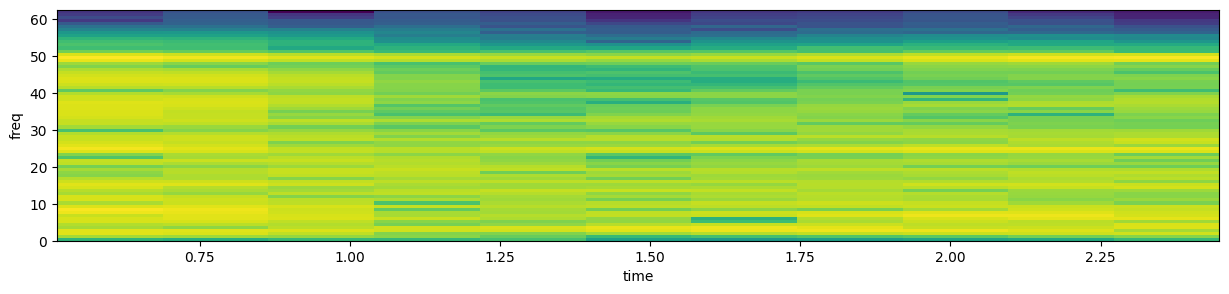

In [81]:
# stft
val_stft = librosa.core.stft(augmented_val_data, n_fft=32)
val_spec = np.abs(val_stft)
test_stft = librosa.core.stft(augmented_test_data, n_fft=32)
test_spec = np.abs(test_stft)

from scipy.fft import rfft, rfftfreq

#ytest = rfft(augmented_val_data[0][0])
#xtest = rfftfreq(375, 1/125)

fig, ax = plt.subplots(figsize=(15,3))
Pxx, freqs, bins, im = ax.specgram(augmented_val_data[0][0], NFFT=150, Fs=125)
#plt.plot(xtest, np.abs(ytest))
ax.set_xlabel("time")
ax.set_ylabel("freq")
plt.show()

Number of frequencies: 33
Number of time steps: 12


C:\Users\Ilya\AppData\Local\Temp\ipykernel_7076\2952968929.py:5: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(val_stft_mne[0], sr=125.00)


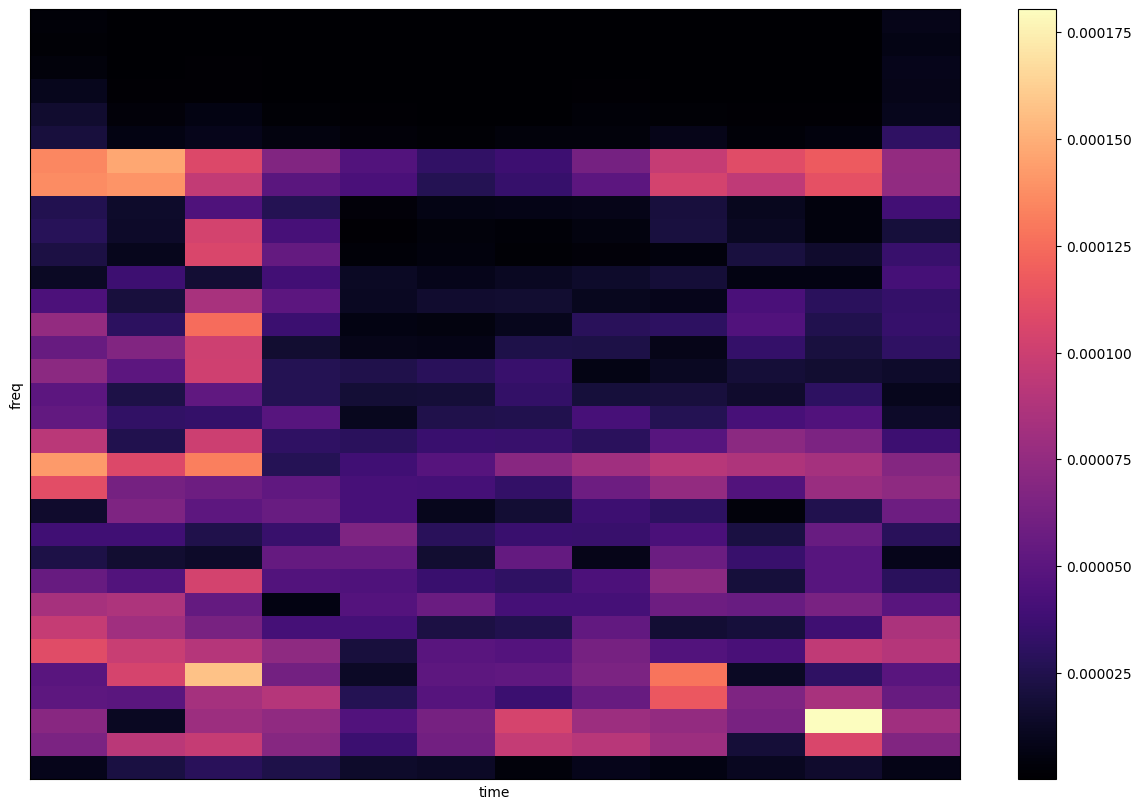

In [88]:
val_stft_mne = mne.time_frequency.stft(x = augmented_val_data[0], wsize = 64)

#mne.time_frequency.Spectrum(val_stft_mne, method = 'auto', fmin = -1, fmax = 1, tmin = 0, tmax = 5, picks = 'all', proj = False, reject_by_annotation = False, n_jobs = -1)
fig, ax = plt.subplots(figsize=(15,10))
librosa.display.specshow(val_stft_mne[0], sr=125.00)
ax.set_xlabel("time")
ax.set_ylabel("freq")
plt.colorbar()
plt.show()

In [13]:
print(test_spec.shape)
print(val_spec.shape)

(429, 8, 33, 24)
(75, 8, 33, 24)


In [51]:
# swap aves
test_spec = test_spec.swapaxes(1,3)
val_spec = val_spec.swapaxes(1,3)

In [60]:
# copy adata rrays
X_train = test_spec.copy()
print(X_train.shape)
X_val = val_spec.copy()
print(X_val.shape)

(4020, 24, 33, 8)
(660, 24, 33, 8)


In [61]:
# reshape for 2d networks
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_val.shape[2]*X_val.shape[3], 1)
print(X_train.shape)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2]*X_val.shape[3], 1)
print(X_val.shape)

(4020, 24, 264, 1)
(660, 24, 264, 1)


In [62]:
# copy marks arrays
Y_train = np.array(test_marks)
print(Y_train.shape)
Y_val = np.array(val_marks)
print(Y_val.shape)

(4020,)
(660,)


In [29]:
#shuffle train and val arrays (not nessesary)
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)
X_val, Y_val =  shuffle(X_val, Y_val, random_state=0)

NameError: name 'Y_train' is not defined

In [63]:
#validation data for neural networks
val = (X_val.copy(), Y_val.copy())
print(X_train.shape)
print(X_val.shape)

(4020, 24, 264, 1)
(660, 24, 264, 1)


In [51]:
#KNN model
model = neighbors.KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train.copy(), Y_train.copy())
print(model.score(X_val.copy(), Y_val.copy()))
cv_results = cross_validate(model, X_val, Y_val, cv = 4)
print(cv_results['test_score'])
pre_Y = model.predict(X_val.copy())
print("true: ", Y_val.copy())
print("pred: ", pre_Y)
print("\n", classification_report(Y_val.copy(), pre_Y))

0.405
[1.   1.   1.   0.98]
true:  [1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0
 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1
 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1
 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1
 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0
 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1]
pred:  [1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0
 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0]

               precision    recall  f1-score   support

           0       0.27      0.20      0.23        88
           1       0.47      0.56

In [22]:
#neural networks

In [68]:
#EEGnet
model = EEGNet(nb_classes = 1, Chans = X_train.shape[1], Samples = X_val.shape[2]*X_val.shape[3], kernLength = 128, dropoutRate = 0.1)
model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 24, 264, 1)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 264, 8)        1024      
                                                                 
 batch_normalization_15 (Ba  (None, 24, 264, 8)        32        
 tchNormalization)                                               
                                                                 
 depthwise_conv2d_5 (Depthw  (None, 1, 264, 16)        384       
 iseConv2D)                                                      
                                                                 
 batch_normalization_16 (Ba  (None, 1, 264, 16)        64        
 tchNormalization)                                               
                                                           

In [22]:
#custom model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(test_spec[0].shape)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 8, 33, 32)         4640      
                                                                 
 batch_normalization_9 (Bat  (None, 8, 33, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 33, 32)         9248      
                                                                 
 batch_normalization_10 (Ba  (None, 8, 33, 32)         128       
 tchNormalization)                                               
                                                                 
 flatten (Flatten)           (None, 8448)              0         
                                                                 
 dense (Dense)               (None, 32)                2

In [69]:
#learning
model.fit(X_train.copy(), Y_train.copy(), epochs=100, validation_data=val)

Epoch 1/100
126/126 [==============================] - 27s 198ms/step - loss: 0.6651 - accuracy: 0.5995 - val_loss: 0.7040 - val_accuracy: 0.3182
Epoch 2/100
126/126 [==============================] - 24s 194ms/step - loss: 0.6350 - accuracy: 0.5995 - val_loss: 0.7197 - val_accuracy: 0.3182
Epoch 3/100
126/126 [==============================] - 23s 179ms/step - loss: 0.6047 - accuracy: 0.5995 - val_loss: 0.7634 - val_accuracy: 0.3182
Epoch 4/100
126/126 [==============================] - 22s 172ms/step - loss: 0.5805 - accuracy: 0.5995 - val_loss: 0.7924 - val_accuracy: 0.3182
Epoch 5/100
126/126 [==============================] - 22s 172ms/step - loss: 0.5569 - accuracy: 0.5995 - val_loss: 0.9373 - val_accuracy: 0.3182
Epoch 6/100
126/126 [==============================] - 22s 171ms/step - loss: 0.5282 - accuracy: 0.5995 - val_loss: 0.8271 - val_accuracy: 0.3182
Epoch 7/100
126/126 [==============================] - 21s 168ms/step - loss: 0.4938 - accuracy: 0.5995 - val_loss: 0.9535 -

In [89]:
classifier = KerasClassifier(model=model, epochs=100, batch_size=16, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(classifier, X_val, Y_val, cv=kfold)
print("Visible: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

INFO:tensorflow:Assets written to: C:\Users\Ilya\AppData\Local\Temp\tmph9ntfsvh\assets


INFO:tensorflow:Assets written to: C:\Users\Ilya\AppData\Local\Temp\tmph9ntfsvh\assets


INFO:tensorflow:Assets written to: C:\Users\Ilya\AppData\Local\Temp\tmp5g2ty4b7\assets


INFO:tensorflow:Assets written to: C:\Users\Ilya\AppData\Local\Temp\tmp5g2ty4b7\assets


INFO:tensorflow:Assets written to: C:\Users\Ilya\AppData\Local\Temp\tmp0_hub7o7\assets


INFO:tensorflow:Assets written to: C:\Users\Ilya\AppData\Local\Temp\tmp0_hub7o7\assets


INFO:tensorflow:Assets written to: C:\Users\Ilya\AppData\Local\Temp\tmpv2l1un5i\assets


INFO:tensorflow:Assets written to: C:\Users\Ilya\AppData\Local\Temp\tmpv2l1un5i\assets


INFO:tensorflow:Assets written to: C:\Users\Ilya\AppData\Local\Temp\tmpkpe5fopp\assets


INFO:tensorflow:Assets written to: C:\Users\Ilya\AppData\Local\Temp\tmpkpe5fopp\assets


Visible: 95.45% (2.83%)


In [68]:
y_pre = model.predict(X_val)
y_res = np.where(y_pre > 0.5, 1, 0)
print("true: ", Y_val.copy())
print("pred: ", y_res.reshape(Y_val.shape))
print("\n", classification_report(Y_val.copy(), y_res))

11/11 [==============================] - 0s 14ms/step
true:  [1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0
 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0
 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0
 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0
 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0
 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1
 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0]
pred:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 

In [69]:
from numpy import round
round(y_pre,3)

array([[1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [0.974],
       [1.   ],
       [0.998],
       [1.   ],
       [1.   ],
       [0.958],
       [1.   ],
       [1.   ],
       [0.995],
       [0.997],
       [1.   ],
       [1.   ],
       [0.999],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [0.999],
       [0.998],
       [1.   ],
       [0.   ],
       [1.   ],
       [1.   ],
       [0.   ],
       [1.   ],
       [0.003],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [0.998],
       [0.259],
       [0.   ],
       [0.999],
       [0.903],
       [1.   ],
       [0.002],
       [1.   ],
       [0.999],
       [1.   ],
       [1.   ],
       [1.   ],
       [0.999],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [0.999],
       [1.   ],
       [